In [16]:
'''
*****************************************************************************************
*
*        		===============================================
*           		Nirikshak Bot (NB) Theme (eYRC 2020-21)
*        		===============================================
*
*  This script is to implement Task 1B of Nirikshak Bot (NB) Theme (eYRC 2020-21).
*  
*  This software is made available on an "AS IS WHERE IS BASIS".
*  Licensee/end user indemnifies and will keep e-Yantra indemnified from
*  any and all claim(s) that emanate from the use of the Software or 
*  breach of the terms of this agreement.
*  
*  e-Yantra - An MHRD project under National Mission on Education using ICT (NMEICT)
*
*****************************************************************************************
'''

# Team ID:			2182
# Author List:		Priyank Sisodia,Pranav Mittal
# Filename:			task_1b.py
# Functions:		applyPerspectiveTransform, detectMaze, writeToCsv
# 					getBorderCoordinates,orderedPolyDp,threshInputImage
# Global variables:	
# 					[ List of global variables defined in this file ]


####################### IMPORT MODULES #######################
## You are not allowed to make any changes in this section. ##
## You have to implement this task with the three available ##
## modules for this task (numpy, opencv, csv)               ##
##############################################################
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
##############################################################



In [17]:

################# ADD UTILITY FUNCTIONS HERE #################
## You can define any utility functions for your code.      ##
## Please add proper comments to ensure that your code is   ##
## readable and easy to understand.                         ##
##############################################################
def orderedPolyDp(corners):
    #ordering all the corners(output of aproxpoly give unordered cordinates of shape)

    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum

    s = corners.sum(axis=2)

    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]

    #print(s)
    #print(rect[0],rect[2])

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    
    diff = np.diff(corners, axis=2)
    #print(diff)

    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]

    #small fault here ,if diff between both is same ???????????????????
    #order = topleft,topright,bottomright,bottomleft
    #print(f"final cordinates:",rect)

    return rect
def getBorderCoordinates(imgMorph):
    #finding the coordinates of corners of maze border
    #finding the ouutermost square
    contours, heirarchy = cv2.findContours(imgMorph,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    #for c in contours:
    #print(len(contours))
    #getting the countour having max area
    row,col=imgMorph.shape
    maxCnt=contours[0]
    maxArea=0
    for cnt in contours:
        area=cv2.contourArea(cnt)
        if((area>maxArea) and (area<row*col*0.95)):
            maxArea=area
            maxCnt=cnt
    perimeter = cv2.arcLength(maxCnt,True)
    corners = cv2.approxPolyDP(maxCnt, 0.01*perimeter,True)
    #image = cv2.polylines(img, cnt,True,(255,0,0),5) 
    #fig.add_subplot(rows,cols,2)
    #plt.imshow(image)
    #print(corners)
    return corners
def threshInputImage(img):
    #thresholding image overall by increasing contrast and features
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgGray = cv2.GaussianBlur(imgGray,(7,7),1)
    
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #imgGray = clahe.apply(imgBlur)
    
    #fig=plt.figure(figsize=(8,8))
    #fig.add_subplot(1,2,1)
    #hist, bins = np.histogram(imgGray.ravel(),256,[0,256]) 
    #plt.plot(hist);
    #fig.add_subplot(1,2,2)
    #hist, bins = np.histogram(imgBlur.ravel(),256,[0,256]) 
    #plt.plot(hist);
    #increase contrast and get a suitable threshold value
    #ret,imgThresh = cv2.threshold(imgBlur,100,255,cv2.THRESH_BINARY)
    ret,imgThresh=cv2.threshold(imgGray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #plt.imshow(cv2.cvtColor(imgThresh,cv2.COLOR_BGR2RGB))
    #fig.add_subplot(1,2,2)
    #Appplying morphological tranformation for better detection of maze and table borders
    kernel = np.ones((5, 5), np.uint8)
    #imgMorph=cv2.erode(imgThresh,kernel,iterations=2)
    #imgBlank = np.zeros_like(img)
    imgCanny = cv2.Canny(imgThresh,80,80)
    #plt.imshow(cv2.cvtColor(imgCanny,cv2.COLOR_BGR2RGB))
    imgMorph=cv2.dilate(imgCanny,kernel,iterations=2)
    
    return imgMorph


In [18]:
def mazeDimension(warped_img):
    #applying hough trasformation on image to calculate the dimensions
    imgGray = cv2.cvtColor(warped_img,cv2.COLOR_BGR2GRAY)
    imgGray = cv2.GaussianBlur(imgGray,(7,7),1)
    ret,imgThresh=cv2.threshold(imgGray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    imgCanny = cv2.Canny(imgThresh,80,80)
    lines= cv2.HoughLines(imgCanny, 1, np.pi/180.0, 150, np.array([]), 0, 0)
    
    #preprocesing the lines to filter some of the options
    bx=lambda x:x[0][0]
    lines=sorted(lines,key=bx)
    
    #taking error between two detcted lines as 30px<1280/11
    errRho=50
    prevVer=0#previous vertical line
    cntVer=1#current count of vertical lines
    prevHor=0#previous horizontal line
    cntHor=1#current count of horizontal lines
    
    #removing repeating lines
    for x in lines:
        rho,theta=x[0][0],x[0][1]
        #angle is 90 deg
        if((np.cos(theta)<0.1)and(np.cos(theta)>-0.1)):
            #checking for repeating lines
            if(abs(prevVer-rho)>errRho):
                #print("Vertical=",prevVer)
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                cv2.line(warped_img,(x1,y1),(x2,y2),(0,0,255),10)
                prevVer=rho
                cntVer=cntVer+1
        #angle is 0 deg
        if((np.cos(theta)<1.1)and(np.cos(theta)>0.9)):
            #checking for repeating lines
            if(abs(prevHor-rho)>errRho):
                #print("Horizontal=",prevHor)
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                cv2.line(warped_img,(x1,y1),(x2,y2),(0,0,255),10)
                prevHor=rho
                cntHor=cntHor+1
    
    #print(lines.shape)
    #for x in lines:
    #    rho,theta=x[0][0],x[0][1]
    #    #print(theta,end=" ")
    #    print(rho,end=" ")
    #    a = np.cos(theta)
    #    b = np.sin(theta)
    #    x0 = a*rho
    #    y0 = b*rho
    #    x1 = int(x0 + 1000*(-b))
    #    y1 = int(y0 + 1000*(a))
    #    x2 = int(x0 - 1000*(-b))
    #    y2 = int(y0 - 1000*(a))

    #    cv2.line(warped_img,(x1,y1),(x2,y2),(0,0,255),10)
    
    plt.imshow(cv2.cvtColor(warped_img,cv2.COLOR_BGR2RGB))
    
    #print(cntVer,cntHor)
    dim=max(cntVer-1,cntHor-1)
    if(dim>8):
        dim=10
    else:
        dim=8
    print(dim)
    return imgCanny,dim

def checkWall(roi):
    #checking for wall in the received roi
    contours, _ = cv2.findContours(roi,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    #for c in contours:
    #print(len(contours))
    #getting the countour having max area
    maxArea=0
    for cnt in contours:
        area=cv2.contourArea(cnt)
        if(area>maxArea):
            maxArea=area
    #print(maxArea)
    w,h=roi.shape
    if(maxArea>w*h/25):
        return True
    else:
        return False
    

##############################################################


In [19]:
def applyPerspectiveTransform(input_img):

    """
    Purpose:
    ---
    takes a maze test case image as input and applies a Perspective Transfrom on it to isolate the maze

    Input Arguments:
    ---
    `input_img` :   [ numpy array ]
        maze image in the form of a numpy array

    Returns:
    ---
    `warped_img` :  [ numpy array ]
        resultant warped maze image after applying Perspective Transform

    Example call:
    ---
    warped_img = applyPerspectiveTransform(input_img)
    """

    warped_img = None

    ##############	ADD YOUR CODE HERE	##############
    
    #taking image-> gray-> canny ->findContour->draw contour on blank image
    img = input_img
    #imgThresh=threshInputImage(img)
    #imgMorph=imgThresh
    #rows=2
    #cols=2
    #fig=plt.figure(figsize=(8,8))
    #fig.add_subplot(rows,cols,1)
    imgThresh=threshInputImage(img)
    #imgThresh=threshInputImage(img)
    #plt.imshow(cv2.cvtColor(imgCanny,cv2.COLOR_BGR2RGB))
    #plt.imshow(cv2.cvtColor(imgMorph,cv2.COLOR_BGR2RGB))
    corners=getBorderCoordinates(imgThresh)
    rect=orderedPolyDp(corners)
    (tl, tr, br, bl) = rect
    #applying perspective transform
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    #print(dst)
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped_img = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    #array=cv2.cvtColor(warped_img,cv2.COLOR_BGR2GRAY).ravel()
    #print(array)
    #hist=[]
    #for i in range(len(array)):
    #    if(array[i]!=255):
    #        hist+=[array[i]]
    #hist, bins = np.histogram(hist,256,[0,256]) 
    #plt.plot(hist);
    #fig.add_subplot(rows,cols,3)
    #plt.imshow(cv2.cvtColor(warped_img,cv2.COLOR_BGR2RGB))
    warped_img = cv2.resize(warped_img, (1280, 1280))
    ##################################################

    return warped_img
#path="test_cases/ball.jpeg"
#path="test_cases/maze01.jpg"
#applyPerspectiveTransform(cv2.imread(path))



[[3, 10, 2, 2, 14, 3, 6, 3, 10, 6],
 [9, 14, 5, 13, 11, 12, 9, 12, 3, 12],
 [3, 6, 5, 3, 10, 6, 3, 10, 12, 7],
 [5, 9, 12, 9, 6, 9, 12, 3, 10, 4],
 [1, 10, 2, 14, 5, 7, 3, 8, 6, 5],
 [5, 7, 9, 6, 5, 5, 5, 3, 12, 5],
 [5, 9, 6, 9, 12, 9, 12, 5, 7, 5],
 [9, 10, 4, 11, 10, 2, 10, 12, 1, 12],
 [3, 10, 12, 3, 6, 5, 3, 6, 9, 6],
 [9, 10, 10, 12, 9, 12, 13, 9, 10, 12]]

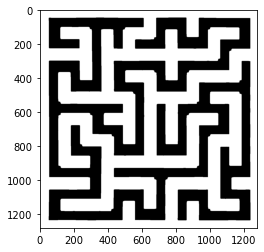

In [26]:

def detectMaze(warped_img):

    """
    Purpose:
    ---
    takes the warped maze image as input and returns the maze encoded in form of a 2D array

    Input Arguments:
    ---
    `warped_img` :    [ numpy array ]
        resultant warped maze image after applying Perspective Transform

    Returns:
    ---
    `maze_array` :    [ nested list of lists ]
        encoded maze in the form of a 2D array

    Example call:
    ---
    maze_array = detectMaze(warped_img)
    """

    maze_array = []

    ##############	ADD YOUR CODE HERE	##############
    
    #plt.imshow(cv2.cvtColor(warped_img,cv2.COLOR_BGR2RGB))
    
    #applying hough trasformation on image to calculate the dimensions
    #get maze dimensions
    #imgCanny,maze=mazeDimension(warped_img)
    maze=10
    resultBitmap=threshInputImage(warped_img)
    
    #applying dilation for better maze detection 
    kernel = np.ones((10, 10), np.uint8)
    resultBitmap=cv2.dilate(resultBitmap,kernel,iterations=4)
    #plt.imshow(cv2.cvtColor(resultBitmap,cv2.COLOR_BGR2RGB))
    
    h,w=resultBitmap.shape
    #print(w,h)
    #maxe of 10 x 10
    w=(int)(w/maze) #width of one unit
    h=(int)(h/maze) #height of one unit
    wall=255#the pixel value at wall
    
    maze_array = np.zeros((maze,maze),dtype=np.uint8)
    #r=0;c=0
    #roi= resultBitmap[(int)(h*r):(int)(h*(r+1)),(int)(w*(c+1)-w/2):(int)(w*(c+1)+w/2)]
    #print((int)(h*r-h/2),(int)(h*r+h/2))
    #rows=1
    #cols=2
    #fig=plt.figure(figsize=(8,8))
    #fig.add_subplot(rows,cols,1)
    #plt.imshow(cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))
    #fig.add_subplot(rows,cols,2)
    #plt.imshow(cv2.cvtColor(resultBitmap,cv2.COLOR_BGR2RGB))
    for r in range(0,maze,1):#row
        for c in range(0,maze,1):#col
            score =0
            top = resultBitmap[h*r+1,(int)(w*c+w/2)]==wall       #point at center of top
            right = resultBitmap[(int)(h*r+h/2),w*(c+1)-1]==wall#point at center of right
            bottom = resultBitmap[h*(r+1)-1,(int)(w*c+w/2)]==wall   #point at center of bottom
            left = resultBitmap[(int)(h*r+h/2),w*c+1]==wall         #point at center of left
            #if(c==0):
            #    print(top,right,bottom,left)
            #cv.circle(resultResize, (50*m+25,50*(n)), 3, (0,0, 255), -1)
            #cv.circle(resultResize, (50*(m+1)-1,50*(n)+25), 3, (0,0, 255), -1)
            #cv.circle(resultResize, (50*m+25,50*(n+1)-1), 3, (0,0, 255), -1)
            #cv.circle(resultResize, (50*m,50*(n)+25), 3, (0,0, 255), -1)
            #t = tp.all()
            #r = rp.all()
            #b = bp.all()
            #l = lp.all()
            
            if top :
                score+=2
            if right:
                score+=4
            if bottom:
                score+=8
            if left:
                score+=1
            maze_array[r,c]=score
            #resultBitmap[h*r+1,(int)(w*c+w/2)]=0       #point at center of top
            #resultBitmap[(int)(h*r+h/2),w*(c+1)-1]=0#point at center of right
            #resultBitmap[h*(r+1)-1,(int)(w*c+w/2)]=0   #point at center of bottom
            #resultBitmap[(int)(h*r+h/2),w*c+1]=0       #point at center of left
    #print(maze_array)
    #print(resultBitmap.shape)
    #cv2.imshow("hm",resultBitmap)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #cv2.imshow("hm",resultbgr)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #cv2.circle(resultBitmap, (cX, cY), 7, (255, 0, 0), -1)
    #plt.imshow(cv2.cvtColor(resultBitmap,cv2.COLOR_BGR2RGB))
    ##################################################
    maze_array=maze_array.tolist()
    return maze_array
#path="test_cases/maze08.jpg"
# path="task_4c_maze_images/maze_t4.jpg"
# cv2.imread(path)
# detectMaze(applyPerspectiveTransform(cv2.imread(path)))



In [ ]:
# NOTE:	YOU ARE NOT ALLOWED TO MAKE ANY CHANGE TO THIS FUNCTION
def writeToCsv(csv_file_path, maze_array):

	"""
	Purpose:
	---
	takes the encoded maze array and csv file name as input and writes the encoded maze array to the csv file

	Input Arguments:
	---
	`csv_file_path` :	[ str ]
		file path with name for csv file to write
	
	`maze_array` :		[ nested list of lists ]
		encoded maze in the form of a 2D array
	
	Example call:
	---
	warped_img = writeToCsv('test_cases/maze00.csv', maze_array)
	"""

	with open(csv_file_path, 'w', newline='') as file:
		writer = csv.writer(file)
		writer.writerows(maze_array)


# In[ ]:


# NOTE:	YOU ARE NOT ALLOWED TO MAKE ANY CHANGE TO THIS FUNCTION
# 
# Function Name:    main
#        Inputs:    None
#       Outputs:    None
#       Purpose:    This part of the code is only for testing your solution. The function first takes 'maze00.jpg'
# 					as input, applies Perspective Transform by calling applyPerspectiveTransform function,
# 					encodes the maze input in form of 2D array by calling detectMaze function and writes this data to csv file
# 					by calling writeToCsv function, it then asks the user whether to repeat the same on all maze images
# 					present in 'test_cases' folder or not. Write your solution ONLY in the space provided in the above
# 					applyPerspectiveTransform and detectMaze functions.

if __name__ == "__main__":

	# path directory of images in 'test_cases' folder
	img_dir_path = 'test_cases/'

	# path to 'maze00.jpg' image file
	file_num = 0
	img_file_path = img_dir_path + 'maze0' + str(file_num) + '.jpg'

	print('\n============================================')
	print('\nFor maze0' + str(file_num) + '.jpg')

	# path for 'maze00.csv' output file
	csv_file_path = img_dir_path + 'maze0' + str(file_num) + '.csv'
	
	# read the 'maze00.jpg' image file
	input_img = cv2.imread(img_file_path)

	# get the resultant warped maze image after applying Perspective Transform
	warped_img = applyPerspectiveTransform(input_img)

	if type(warped_img) is np.ndarray:

		# get the encoded maze in the form of a 2D array
		maze_array = detectMaze(warped_img)

		if (type(maze_array) is list) and (len(maze_array) == 10):

			print('\nEncoded Maze Array = %s' % (maze_array))
			print('\n============================================')
			
			# writes the encoded maze array to the csv file
			writeToCsv(csv_file_path, maze_array)

			cv2.imshow('warped_img_0' + str(file_num), warped_img)
			cv2.waitKey(0)
			cv2.destroyAllWindows()
		
		else:

			print('\n[ERROR] maze_array returned by detectMaze function is not complete. Check the function in code.\n')
			exit()
	
	else:

		print('\n[ERROR] applyPerspectiveTransform function is not returning the warped maze image in expected format! Check the function in code.\n')
		exit()
	
	choice = input('\nDo you want to run your script on all maze images ? => "y" or "n": ')

	if choice == 'y':

		for file_num in range(1, 10):
			
			# path to image file
			img_file_path = img_dir_path + 'maze0' + str(file_num) + '.jpg'

			print('\n============================================')
			print('\nFor maze0' + str(file_num) + '.jpg')

			# path for csv output file
			csv_file_path = img_dir_path + 'maze0' + str(file_num) + '.csv'
			
			# read the image file
			input_img = cv2.imread(img_file_path)

			# get the resultant warped maze image after applying Perspective Transform
			warped_img = applyPerspectiveTransform(input_img)
            
			if type(warped_img) is np.ndarray:

				# get the encoded maze in the form of a 2D array
				maze_array = detectMaze(warped_img)

				if (type(maze_array) is list) and (len(maze_array) == 10):

					print('\nEncoded Maze Array = %s' % (maze_array))
					print('\n============================================')
					
					# writes the encoded maze array to the csv file
					writeToCsv(csv_file_path, maze_array)

					cv2.imshow('warped_img_0' + str(file_num), warped_img)
					cv2.waitKey(0)
					cv2.destroyAllWindows()
				
				else:

					print('\n[ERROR] maze_array returned by detectMaze function is not complete. Check the function in code.\n')
					exit()
			
			else:

				print('\n[ERROR] applyPerspectiveTransform function is not returning the warped maze image in expected format! Check the function in code.\n')
				exit()

	else:

		print('')

